<h1 align="center"> Capacitive ADC High-Level Modelling </h1>

In [1]:
from functools import partial

# mathematical computing
import numpy as np
import scipy as sp
from scipy import signal # to generate the noise signal
import seaborn as sns # to observe the noise signal's histogram

sns.set_theme()
sns.set_palette("colorblind")

from numpy.random import uniform, normal # random numbers fitted into a uniform distribution
# plotting
import matplotlib.pyplot as plt
# import the models and utilities functions
from utils import dec2bin, bin2dec

%matplotlib inline

In [2]:
# number of simulation points
Np = 2**13
# define the time base
Fs = 1e9 # Hz
Ts = 1/Fs # s
tD = np.arange(0,Np)*Ts; # (0:Np-1) == np.arange(0,Np)

In [3]:
# scales
# volts 
V   = 1.0
mV  = V*1e-3
uV  = V*1e-6
nV  = V*1e-9

# seconds
s  = 1.0
ms = s*1e-3
us = s*1e-6
ns = s*1e-9

# frequency
Hz = 1.0
kHz = Hz*1e3
MHz = Hz*1e6
GHz = Hz*1e9

# length
m  = 1.0
mm = m*1e-3
um = m*1e-6
nm = m*1e-9

# farad
F  = 1.0
pF = F*1e-12
fF = F*1e-15

In [4]:
ENABLE_NOISE = False # enable noise supperposed to the input signal
vn_mean = 0.0*V     # mean of the noise signal
vn_std  = 1*mV    # standard deviation of the noise signal
vn_in   = normal(vn_mean, vn_std, Np) # generate the gaussian/white (random) noise signal

In [5]:
# observe the noise signal
if ENABLE_NOISE:
    fig, ax = plt.subplots(figsize=(4,3))
    sns.histplot(vn_in, ax=ax, kde=True, stat='probability', color='gray', label='noise signal')
    ax.set_xlabel('Voltage [V]')
    ax.set_ylabel('Probability density')
    ax.set_title('Histogram of the noise signal')
    plt.show()

In [6]:
vdd     = 1.0
vss     = 0.0
vcm     = np.mean([vdd, vss])
vref    = vdd

# setup the input signal of the first sub ADC
A1      = vref
fbin    = 7
f1      = fbin*(Fs/Np)
ph1     = 0
vin1t   = A1*np.sin(2*np.pi*f1*tD + ph1) + vcm

if ENABLE_NOISE:
    vin1t = vin1t + vn_in

# compute the spectrum of the input signal
vin1f           = np.abs(np.fft.fftshift(np.fft.fft(vin1t) / Np))  # [V] # voltage in the frequency axis
# NOTE: fft(yf) is divided by Np in order to normalize the resulting frequency spectrum from the digital fourier transform
fD              = np.fft.fftshift(np.fft.fftfreq(Np, Ts))  # [Hz] # frequency axis
power_vin1f     = (vin1f*vin1f) # [V^2] - square the voltage spectrum to obtain the power spectrum
power_vinf_dB   = 10 * np.log10(power_vin1f)  # [dB] - convert the power spectrum to dB

/var/folders/vv/xctyh4bd2td6k2w_gvh_t2vr0000gn/T/ipykernel_15341/2358800433.py:21: RuntimeWarning: divide by zero encountered in log10
  power_vinf_dB   = 10 * np.log10(power_vin1f)  # [dB] - convert the power spectrum to dB


## Monte Carlo Simulation Setup

In [7]:
# CONTROL VARIABLES FOR ALL SIMULATIONS
# setup mponte carlo analysis
NUM_CIRCUITS        = 1000 # number of circuits in monte carlo simulation
CAP_MISMATCH_MEAN   = 0.0
CAP_MISMATCH_STD    = 0.01 # 1% Capacitance mismatch
NUM_COMP_OFSTS      = 5 # number of comparator offsets to be simulated
MAX_COMP_OFST       = 5*mV # maximum comparator offset

<h2 align="left"> Successive Approximation Register (SAR) ADC - Bottom Plate Sampling </h2>

<p align="justify">
    The SAR ADC is a type of ADC that uses a binary search algorithm to find the input voltage. The SAR ADC is composed of a DAC, a comparator, and a SAR control logic and register. The binary search divides the search domain in 2 in each conversion step, making the input voltage of the comparator to approximate the input voltage of the ADC in each step, by reprogramming each of the bits of the intrinsic DAC to uncover which is the digital word that best represents vin.
</p>

INSERIR IMAGEM DE UM SAR ADC CLÁSSICO

INSERIR IMAGEM DA OPERAÇÃO DE DIVISÃO DO DOMÍNIO DE BUSCA

INSERIR IMAGEM DA CONFIGURAÇÃO DO ADC EM CADA PASSO DE CONVERSÃO

In [8]:
# setup the ADC parameters
vref      = vdd   # reference voltage of the whole 2-step adc

adc_gain  = 1
vref      = vref / adc_gain
vrefp     = vcm + vref/2
vrefn     = vcm - vref/2
Nbits     = 10
vlsb      = vref/(2**Nbits)

vin1    = np.linspace(vrefn, vrefp, Np) # ramp input for an equal probability distribution of the input signal

In [9]:
avg_linearity = np.zeros(NUM_COMP_OFSTS)
linearities = np.zeros((NUM_CIRCUITS, NUM_COMP_OFSTS))

adc_offsets = np.zeros((NUM_CIRCUITS, NUM_COMP_OFSTS))
adc_eos     = np.zeros((NUM_CIRCUITS, NUM_COMP_OFSTS))
adc_gainerr = np.zeros((NUM_CIRCUITS, NUM_COMP_OFSTS))


comp_offsets = np.linspace(0, MAX_COMP_OFST, NUM_COMP_OFSTS)

#vin1 = np.array([vrefn, vcm/2, vcm,  vrefp])

for i, comp_ofst in enumerate(comp_offsets):
    for j in range(NUM_CIRCUITS):
        
        # setup CDAC capacitor array
        unitary_caps    = np.ones(2**Nbits)
        # setup random capacitor mismatch 
        cap_error       = normal(CAP_MISMATCH_MEAN, CAP_MISMATCH_STD, len(unitary_caps))
        caps            = unitary_caps*( 1 + cap_error)
        num_caps_cdac   = Nbits # number of capacitors in the CDAC array (N-1 binary weighted capacitors + 1 residue capacitor)
        # setup residue capacitor
        cres = caps[-1] # the last capacitor never gets accessed when aggregating the capacitors in the CDAC array
        # aggregate the capacitors in the CDAC array
        cdac = np.array([
            np.sum(caps[2**k - 1:2**(k+1)-1])
            for k in range(num_caps_cdac)
        ])
        cdac = cdac[::-1] # reverse the array to match the binary weighted architecture
        
        ctotal = np.sum(cdac) + cres
        
        # setup the comparator
        # the comparator is centered at vcm in this single ended architecture
        vcomp = vcm + normal(0.0, comp_ofst, 1)[0] # comparator offset
        
        # setup the CDAC's top plate node voltage
        vx = np.zeros( (Nbits + 2, len(vin1)) ) # two aditional phases are required to sample and pass vin to the top plate
        
        # because we are performing bot plate sampling, 
        # the top plate is always connected to vcm in the 
        # first sampling phase
        vx[0,:] = vcm
        
        # parse the input signal to the CDAC's top plate
        vx[1,:] = (vcm - vin1) + vrefn
        
        # setup the binary array that enables the control 
        # of the capacitors connected to Vrefp and Vrefn
        # in the CDAC array
        dout     = np.zeros( (Nbits, len(vin1)) ) # output of the control logic
        dout_neg = 1 - dout
        
        
        # compute the total capacitance connected to Vrefp
        cvrefp = dout.T @ cdac.reshape(-1, 1)
        # compute the total capacitance connected to Vrefn initially
        cvrefn = dout_neg.T @ cdac.reshape(-1, 1) + cres
            
        cvrefp_old = cvrefp.T # generic way! (its actually a null vector)
        cvrefn_old = cvrefn.T
        
        # setup the charge array to register 
        # the amount of charge drawn from Vrefp
        charge_vrefp = np.zeros( (Nbits+2, len(vin1)) )
        
        # perform each conversion step
        for k in range(2, Nbits+2):
            # setup the control logic to use the DAC array to check 
            # if the input signal is greater than the top plate voltage
            dout[k-2,:] = 1
            dout_neg[k-2,:] = 1 - dout[k-2,:]
            # compute the total capacitance connected to Vrefp
            cvrefp = dout.T @ cdac.reshape(-1, 1)
            # compute the total capacitance connected to Vrefn
            cvrefn = dout_neg.T @ cdac.reshape(-1, 1) + cres
            
            cvrefp = cvrefp.T
            cvrefn = cvrefn.T
            # compute the top plate voltage using charge conservation principle
            # between successive phases
            vx[k,:] = vx[k-1,:] + ( vrefn*(cvrefn - cvrefn_old) + vrefp*(cvrefp - cvrefp_old) ) / ctotal
            # compute the amount of charge drawn from Vrefp
            charge_vrefp[k,:] = (cvrefp - cvrefp_old) * vrefp
            
            # compare the top plate voltage with the comparator threshold and update the control logic            
            dout[k-2,:] = (vx[k,:] < vcomp).astype(int)
            dout_neg[k-2,:] = 1 - dout[k-2,:]
            # update the old capacitance values
            cvrefp_old = cvrefp
            cvrefn_old = cvrefn
        
        # obtain the residue voltage
        vres = vx[-1,:] - vrefn
        
        # obtain the amount of energy drawn from Vrefp
        energy_vrefp = np.sum(charge_vrefp, axis=0) * vrefp
        
        # comput the non linear errors of the adc
        # compute the transition voltages of the ADC and its inl / dnl
        dout_dec        = bin2dec(dout, width=Nbits, reverse=False)
        dout_dec_trans  = dout_dec[ np.where(np.diff(dout_dec) > 0 ) ]
        vtrans          = vin1[ np.where(np.diff(dout_dec) > 0 ) ]
        
        vlsb_measured = (vtrans[-1] - vtrans[0])/(2**Nbits - 2)
        dnl = np.diff(vtrans)/vlsb_measured - 1
        inl = np.array([0] + np.cumsum(dnl).tolist())
        adc_linearity = Nbits - np.log2(np.max(inl) - np.min(inl))
        linearities[j, i] = adc_linearity
        
        # compute the linear errors of the adc
        # offset error
        offset              = (vtrans[-1] - vtrans[0])/vlsb
        adc_offsets[j, i]   = offset
        # end of scale error
        eos_error       = (vtrans[-1] - (2**Nbits - 1)*vlsb)/vlsb
        adc_eos[j, i]   = eos_error
        # gain error
        gain_error          = 100*( (vtrans[-1] - vtrans[0])/((2**Nbits - 1)*vlsb - 0) - 1 )
        adc_gainerr[j, i]   = gain_error

    avg_linearity[i] = np.mean(linearities[:, i])
    
print("CDAC Capacitance     : ", cdac, " (F/F)")
print("Residue Capacitance  : ", cres, " (F/F)")
print("Total Capacitance    : ", ctotal, " (F/F)")
print("Comparator Threshold : ", vcomp/mV, " (mV)")

CDAC Capacitance     :  [511.97530712 255.92816308 127.98442155  63.77327061  31.98500169
  16.06588065   7.99467869   3.99934378   1.98705146   0.99327651]  (F/F)
Residue Capacitance  :  1.0044461767167356  (F/F)
Total Capacitance    :  1023.6908413210913  (F/F)
Comparator Threshold :  498.230104219368  (mV)


Text(0.5, 1.0, 'ADC Transfer Function')

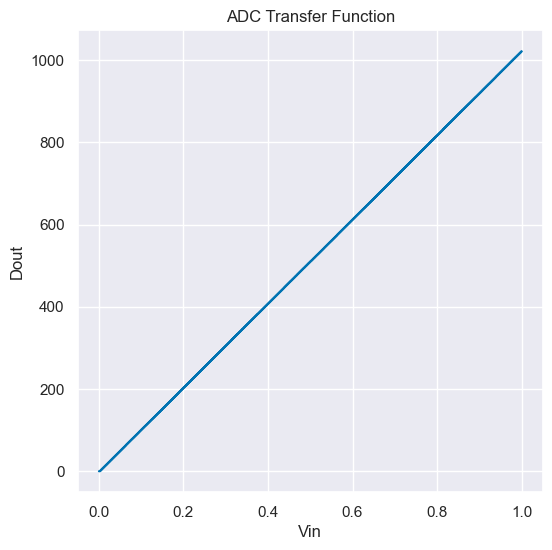

In [10]:
# observe dout against vin
fig, ax = plt.subplots(figsize=(6, 6))
ax.step(vin1, dout_dec)
ax.set_xlabel('Vin')
ax.set_ylabel('Dout')
ax.grid(True)
ax.set_title('ADC Transfer Function')

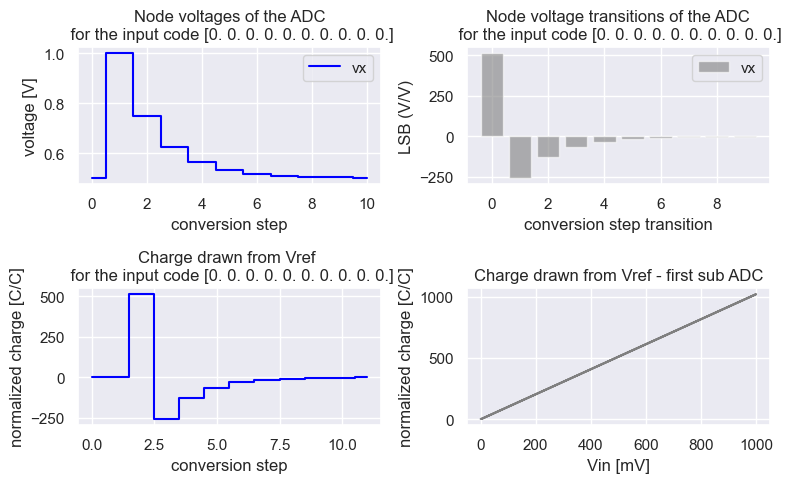

In [11]:
# observe the voltages at the vp and vn nodes of the first sub ADC in each conversion step
fig, ax = plt.subplots(2,2,figsize=(8,5))
#vin = vtrans_first[len(vtrans_first)//2]
#idx = len(vp_first[0, :])//2 + 1
idx = 0

ax[0,0].step(list(range(len(vx[:, idx][1:]))),vx[:, idx][1:], label='vx', color='blue', where="mid")
ax[0,0].set_xlabel('conversion step')
ax[0,0].set_ylabel('voltage [V]')
ax[0,0].set_title(f'Node voltages of the ADC\n for the input code {dout[:,idx]}')
ax[0,0].grid(True)
ax[0,0].legend()

# plot the difference between each vn and vp node voltages in relation to the true measured vlsb
vx_trans = np.diff(vx[:, idx][1:])/vlsb_measured
ax[0,1].bar(list(range(len(vx_trans))), vx_trans, label="vx", color="gray", alpha=0.6)
ax[0,1].set_xlabel('conversion step transition')
ax[0,1].set_ylabel('LSB (V/V)')
ax[0,1].set_title(f'Node voltage transitions of the ADC\n for the input code {dout[:,idx]}')
ax[0,1].grid(True)
ax[0,1].legend()


# observe the charge at the end of each conversion step
ax[1,0].step(list(range(len(charge_vrefp))), charge_vrefp[:, idx], label='charge drawn from vref', color='blue', where="mid")
ax[1,0].set_xlabel('conversion step')
ax[1,0].set_ylabel('normalized charge [C/C]')
ax[1,0].set_title(f'Charge drawn from Vref \n for the input code {dout[:,idx]}')
ax[1,0].grid(True)

# observe the energy drawn from vrefp
ax[1,1].step(vin1/mV, energy_vrefp, label='energy drawn from vref', color='gray', where="mid")
ax[1,1].set_xlabel('Vin [mV]')
ax[1,1].set_ylabel('normalized charge [C/C]')
ax[1,1].set_title('Charge drawn from Vref - first sub ADC')
ax[1,1].grid(True)

fig.tight_layout()

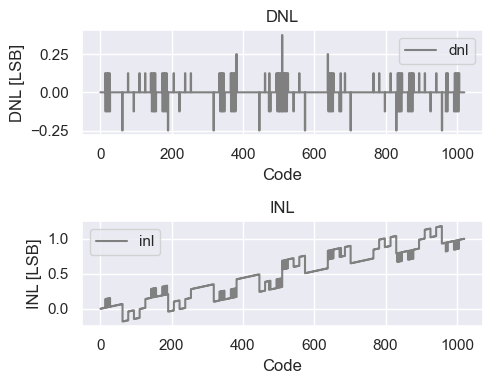

In [12]:
# observe the inl and dnl
fig, ax = plt.subplots(2,1,figsize=(5, 4))
ax[1].step(dout_dec_trans, inl, label='inl', color='gray')
ax[1].set_xlabel('Code')
ax[1].set_ylabel('INL [LSB]')
ax[1].set_title('INL')
ax[1].grid(True)
ax[1].legend()
ax[0].step(dout_dec_trans[:-1], dnl, label='dnl', color='gray')
ax[0].set_xlabel('Code')
ax[0].set_ylabel('DNL [LSB]')
ax[0].set_title('DNL')
ax[0].grid(True)
ax[0].legend()
fig.tight_layout()


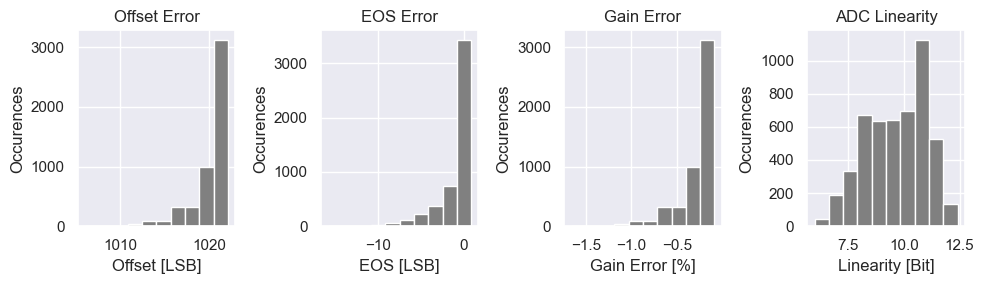

In [13]:
# observe the histogram of the linear errors of the ADC
fig, ax = plt.subplots(1,4,figsize=(10, 3))
ax[0].hist(adc_offsets.flatten(), bins=10, label='offset', color='gray')
ax[0].set_xlabel('Offset [LSB]')
ax[0].set_ylabel('Occurences')
ax[0].set_title('Offset Error')
ax[0].grid(True)
#ax[0].legend()
ax[1].hist(adc_eos.flatten(), bins=10, label='eos', color='gray')
ax[1].set_xlabel('EOS [LSB]')
ax[1].set_ylabel('Occurences')
ax[1].set_title('EOS Error')
ax[1].grid(True)
#ax[1].legend()
ax[2].hist(adc_gainerr.flatten(), bins=10, label='gain', color='gray')
ax[2].set_xlabel('Gain Error [%]')
ax[2].set_ylabel('Occurences')
ax[2].set_title('Gain Error')
ax[2].grid(True)

ax[3].hist(linearities.flatten(), bins=10, label='linearity', color='gray')
ax[3].set_xlabel('Linearity [Bit]')
ax[3].set_ylabel('Occurences')
ax[3].set_title('ADC Linearity')
ax[3].grid(True)
#ax[2].legend()
fig.tight_layout()

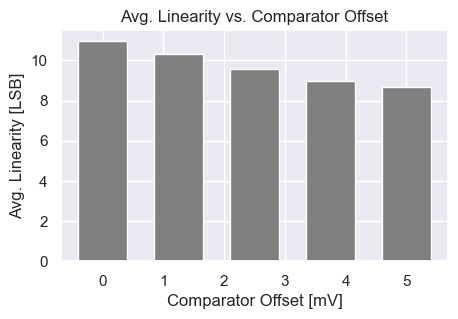

In [14]:
# observe the average linearity of the ADC against comparator offset
fig, ax = plt.subplots(1,1,figsize=(5, 3))
ax.bar(comp_offsets/mV, avg_linearity, label='avg linearity', color='gray')
ax.set_xlabel('Comparator Offset [mV]')
ax.set_ylabel('Avg. Linearity [LSB]')
ax.set_title('Avg. Linearity vs. Comparator Offset')
ax.grid(True)

<h2 align="left"> Differential Successive Approximation Register (SAR) ADC - Bottom Plate Sampling </h2>

<p align="justify">
    
</p>

INSERIR IMAGEM DE UM SAR ADC DIFERENCIAL COM BOT PLATE SAMPLING

INSERIR IMAGEM DA OPERAÇÃO DE DIVISÃO DO DOMÍNIO DE BUSCA E EXPLICAR O PORQUE DE NAO PRECISAR DE USAR O DAC PARA DETERMINAR O PRIMEIRO BIT

INSERIR IMAGEM DA CONFIGURAÇÃO DO ADC EM CADA PASSO DE CONVERSÃO

In [15]:
# setup the ADC parameters
vref      = vdd   # reference voltage of the whole 2-step adc

adc_gain  = 1
vref      = vref / adc_gain
vrefp     = vcm + vref/2
vrefn     = vcm - vref/2
Nbits     = 10
vlsb      = vref/(2**Nbits)

vin1    = np.linspace(-vref, vref, Np) # ramp input for an equal probability distribution of the input signal
vin1p   = vin1/2 + vcm
vin1n   = -vin1/2 + vcm

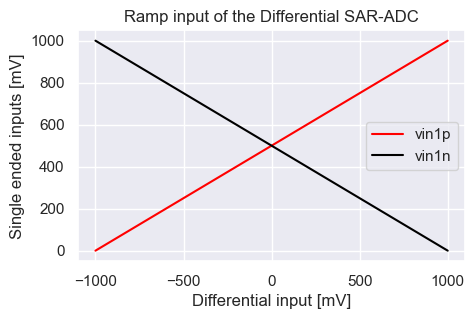

In [16]:
# observe the ramp inputs of the adc
fig, ax = plt.subplots(1,1,figsize=(5, 3))
ax.plot(vin1/mV, vin1p/mV, label='vin1p', color='red')
ax.plot(vin1/mV, vin1n/mV, label='vin1n', color='black')
ax.set_xlabel('Differential input [mV]')
ax.set_ylabel('Single ended inputs [mV]')
ax.set_title('Ramp input of the Differential SAR-ADC')
ax.grid(True)
ax.legend()

In [17]:
avg_linearity = np.zeros(NUM_COMP_OFSTS)
linearities = np.zeros((NUM_CIRCUITS, NUM_COMP_OFSTS))

adc_offsets = np.zeros((NUM_CIRCUITS, NUM_COMP_OFSTS))
adc_eos     = np.zeros((NUM_CIRCUITS, NUM_COMP_OFSTS))
adc_gainerr = np.zeros((NUM_CIRCUITS, NUM_COMP_OFSTS))


comp_offsets = np.linspace(0, MAX_COMP_OFST, NUM_COMP_OFSTS)

#vin1 = np.array([-vrefp, -vcm/2, vrefn, vcm, vrefp])
#vin1 = np.array([vcm,  vrefp])
vin1p   = vin1/2 + vcm
vin1n   = -vin1/2 + vcm

for i, comp_ofst in enumerate(comp_offsets):
    for j in range(NUM_CIRCUITS):
        
        # setup CDAC capacitor array
        
        # NOTE: In this architecture, the first sampling phase 
        # can be used to directly obtain the MSB of the ADC
        # and as such we don't need to use the CDAC array in the first phase
        # removing the necessity of the MSB capacitor in the CDAC array
        
        # positive comparator input rail
        num_caps_cdac   = Nbits # number of capacitors in the CDAC array (N-1 binary weighted capacitors + 1 residue capacitor)
        unitary_caps    = np.ones(2**(num_caps_cdac))
        # setup random capacitor mismatch 
        cap_error       = normal(CAP_MISMATCH_MEAN, CAP_MISMATCH_STD, len(unitary_caps))
        caps            = unitary_caps*( 1 + cap_error)
        # setup residue capacitor
        pos_cres = caps[-1] # the last capacitor never gets accessed when aggregating the capacitors in the CDAC array
        # aggregate the capacitors in the CDAC array
        pos_cdac = np.array([
            np.sum(caps[2**k - 1:2**(k+1)-1])
            for k in range(num_caps_cdac)
        ])
        pos_cdac = pos_cdac[::-1] # reverse the array to match the binary weighted architecture
        pos_ctotal = np.sum(pos_cdac) + pos_cres
        
        # negative comparator input rail
        #num_caps_cdac   = Nbits # number of capacitors in the CDAC array (N binary weighted capacitors + 1 residue capacitor)
        unitary_caps    = np.ones(2**(num_caps_cdac))
        # setup random capacitor mismatch 
        cap_error       = normal(CAP_MISMATCH_MEAN, CAP_MISMATCH_STD, len(unitary_caps))
        caps            = unitary_caps*( 1 + cap_error)
        
        # setup residue capacitor
        neg_cres = caps[-1] # the last capacitor never gets accessed when aggregating the capacitors in the CDAC array
        # aggregate the capacitors in the CDAC array
        neg_cdac = np.array([
            np.sum(caps[2**k - 1:2**(k+1)-1])
            for k in range(num_caps_cdac)
        ])
        neg_cdac = neg_cdac[::-1] # reverse the array to match the binary weighted architecture
        neg_ctotal = np.sum(neg_cdac) + neg_cres
        
        # setup the comparator
        # the comparator is centered at vcm in this single ended architecture
        vcomp_offset = normal(0.0, comp_ofst, 1)[0] # comparator offset
        
        # setup the CDAC's top plate node voltage
        vp = np.zeros( (Nbits+2, len(vin1)) ) # an aditional phase is required when sampling vin to the bot plate 
        vn = np.zeros( (Nbits+2, len(vin1)) )
        
        # sampling phase : bottom plate sampling
        vp[0,:] = vcm
        vn[0,:] = vcm
        
        # setup the binary array that enables the control 
        # of the capacitors connected to Vrefp and Vrefn
        # in the CDAC array
        dout     = np.zeros( (Nbits, len(vin1)) ) # output of the control logic
        dout_neg = 1-dout
        
        
        # positive comparator input rail
        # compute the total capacitance connected to Vrefp
        cpos_vrefp = dout.T @ pos_cdac.reshape(-1, 1) 
        # compute the total capacitance connected to Vrefn
        # after connecting all the capacitors to Vrefn
        cpos_vrefn = dout_neg.T @ pos_cdac.reshape(-1, 1) + pos_cres
        
        # negative comparator input rail
        # compute the total capacitance connected to Vrefp
        # after connecting all the capacitors to Vrefp
        cneg_vrefp = dout_neg.T @ neg_cdac.reshape(-1, 1) + neg_cres
        # compute the total capacitance connected to Vrefn
        cneg_vrefn = dout.T @ neg_cdac.reshape(-1, 1) 
        
        cpos_vrefp_old = cpos_vrefp.T # generic way! (its actually a null vector)
        cpos_vrefn_old = cpos_vrefn.T
        
        cneg_vrefp_old = cneg_vrefp.T
        cneg_vrefn_old = cneg_vrefn.T
        
        # setup the charge array to register 
        # the amount of charge drawn from Vrefp
        charge_vrefp = np.zeros( (Nbits+1, len(vin1)) )
        
        charge_vrefp[0,:] = vrefp*(cpos_vrefp_old + cneg_vrefp_old)
        
        # second phase: pass vin to the top plate
        vp[1,:] = (vcm - vin1p) + vrefn
        vn[1,:] = (vcm - vin1n) + vrefp
        
        
        # perform each conversion step
        for k in range(2, Nbits+2):
            # setup the control logic to use the DAC array to check 
            # if the input signal is greater than the top plate voltage
            # (NON-MONOTONIC APPROACH)
            dout[k-2,:] = 1
            dout_neg[k-2,:] = 1 - dout[k-2,:]
            
            # compute the total capacitance connected to Vrefp
            cpos_vrefp = dout.T @ pos_cdac.reshape(-1, 1) 
            # compute the total capacitance connected to Vrefn
            cpos_vrefn = dout_neg.T @ pos_cdac.reshape(-1, 1) + pos_cres
            
            cpos_vrefp = cpos_vrefp.T
            cpos_vrefn = cpos_vrefn.T
            
            # compute the total capacitance connected to Vrefp
            cneg_vrefp = dout_neg.T @ neg_cdac.reshape(-1, 1) + neg_cres
            # compute the total capacitance connected to Vrefn
            cneg_vrefn = dout.T @ neg_cdac.reshape(-1, 1) 
            
            cneg_vrefp = cneg_vrefp.T
            cneg_vrefn = cneg_vrefn.T
            
            # compute the top plate voltage using charge conservation principle
            # between successive phases
            vp[k,:] = vp[k-1,:] + ( vrefn*(cpos_vrefn - cpos_vrefn_old) + vrefp*(cpos_vrefp - cpos_vrefp_old) ) / pos_ctotal
            vn[k,:] = vn[k-1,:] + ( vrefn*(cneg_vrefn - cneg_vrefn_old) + vrefp*(cneg_vrefp - cneg_vrefp_old) ) / neg_ctotal
            
            # compute the amount of charge drawn from Vrefp
            charge_vrefp[k-1,:] = vrefp*(cpos_vrefp + cneg_vrefp)
            # compute the amount of charge drawn from Vrefp
            
            dout[k-2,:] = ( vp[k,:] - vn[k,:] < vcomp_offset ).astype(int)
            dout_neg[k-2,:] = 1 - dout[k-2,:]
            
            # update the old capacitance values
            cpos_vrefp_old = cpos_vrefp
            cpos_vrefn_old = cpos_vrefn
            
            cneg_vrefp_old = cneg_vrefp
            cneg_vrefn_old = cneg_vrefn
        
        # obtain the residue voltage
        vres = vp[-1,:] - vn[-1,:]
        
        # obtain the amount of energy drawn from Vrefp
        energy_vrefp = np.sum(charge_vrefp, axis=0) * vrefp
        
        # comput the non linear errors of the adc
        # compute the transition voltages of the ADC and its inl / dnl
        dout_dec        = bin2dec(dout, width=Nbits, reverse=False)
        dout_dec_trans  = dout_dec[ np.where(np.diff(dout_dec) > 0 ) ]
        vtrans          = vin1[ np.where(np.diff(dout_dec) > 0 ) ]
        
        vlsb_measured = (vtrans[-1] - vtrans[0])/(2**Nbits - 2)
        dnl = np.diff(vtrans)/vlsb_measured - 1
        inl = np.array([0] + np.cumsum(dnl).tolist())
        adc_linearity = Nbits - np.log2(np.max(inl) - np.min(inl))
        linearities[j, i] = adc_linearity
        
        # compute the linear errors of the adc
        # offset error
        offset              = (vtrans[-1] - vtrans[0])/vlsb
        adc_offsets[j, i]   = offset
        # end of scale error
        eos_error       = (vtrans[-1] - (2**Nbits - 1)*vlsb)/vlsb
        adc_eos[j, i]   = eos_error
        # gain error
        gain_error          = 100*( (vtrans[-1] - vtrans[0])/((2**Nbits - 1)*vlsb - 0) - 1 )
        adc_gainerr[j, i]   = gain_error
        

    avg_linearity[i] = np.mean(linearities[:, i])
    
print("CDAC Capacitance     : ", pos_cdac, " (F/F)")
print("Residue Capacitance  : ", pos_cres, " (F/F)")
print("Total Capacitance    : ", pos_ctotal, " (F/F)")
print("Comparator Threshold : ", vcomp_offset/mV, " (mV)")

CDAC Capacitance     :  [511.90325591 256.22148783 127.88262658  63.98491656  31.99409227
  15.96845487   7.99502927   4.01002754   1.9870096    1.005354  ]  (F/F)
Residue Capacitance  :  0.9953477854361955  (F/F)
Total Capacitance    :  1023.9476022209874  (F/F)
Comparator Threshold :  -5.515303407611585  (mV)


/var/folders/vv/xctyh4bd2td6k2w_gvh_t2vr0000gn/T/ipykernel_15341/1497454566.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


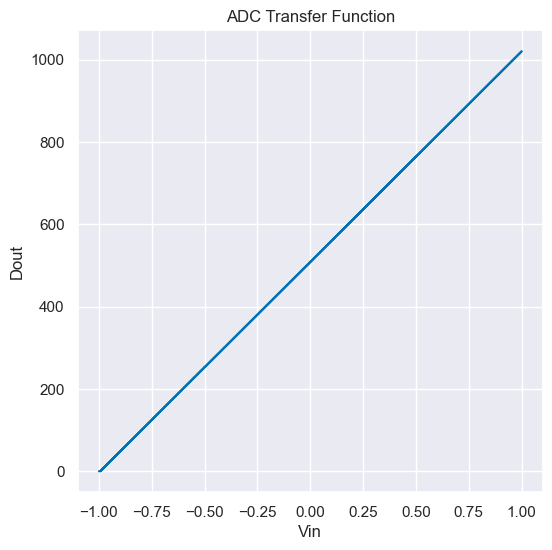

In [18]:
# observe dout against vin
fig, ax = plt.subplots(figsize=(6, 6))
ax.step(vin1, dout_dec)
ax.set_xlabel('Vin')
ax.set_ylabel('Dout')
ax.grid(True)
ax.set_title('ADC Transfer Function')
fig.show()

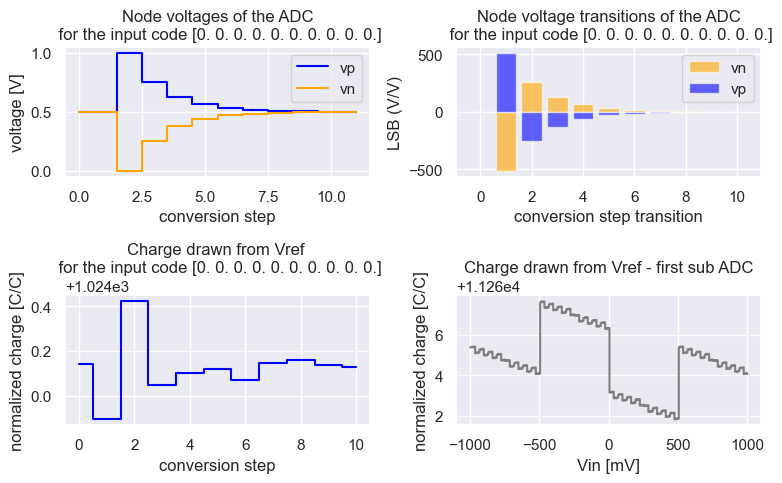

In [19]:
# observe the voltages at the vp and vn nodes of the first sub ADC in each conversion step
fig, ax = plt.subplots(2,2,figsize=(8,5))
#vin = vtrans_first[len(vtrans_first)//2]
#idx = len(vp_first[0, :])//2 + 1
idx = 0

ax[0,0].step(list(range(len(vp[:, idx][0:]))),vp[:, idx][0:], label='vp', color='blue', where="mid")
ax[0,0].step(list(range(len(vn[:, idx][0:]))),vn[:, idx][0:], label='vn', color='orange', where="mid")
ax[0,0].set_xlabel('conversion step')
ax[0,0].set_ylabel('voltage [V]')
ax[0,0].set_title(f'Node voltages of the ADC\n for the input code {dout[:,idx]}')
ax[0,0].grid(True)
ax[0,0].legend()

# plot the difference between each vn and vp node voltages in relation to the true measured vlsb
vn_trans = np.diff(vn[:, idx][0:])/vlsb
vp_trans = np.diff(vp[:, idx][0:])/vlsb
ax[0,1].bar(list(range(len(vn_trans))), vn_trans, label="vn", color="orange", alpha=0.6)
ax[0,1].bar(list(range(len(vp_trans))), vp_trans, label="vp", color="blue", alpha=0.6)
ax[0,1].set_xlabel('conversion step transition')
ax[0,1].set_ylabel('LSB (V/V)')
ax[0,1].set_title(f'Node voltage transitions of the ADC\n for the input code {dout[:,idx]}')
ax[0,1].grid(True)
ax[0,1].legend()


# observe the charge at the end of each conversion step
ax[1,0].step(list(range(len(charge_vrefp))), charge_vrefp[:, idx], label='charge drawn from vref', color='blue', where="mid")
ax[1,0].set_xlabel('conversion step')
ax[1,0].set_ylabel('normalized charge [C/C]')
ax[1,0].set_title(f'Charge drawn from Vref \n for the input code {dout[:,idx]}')
ax[1,0].grid(True)

# observe the energy drawn from vrefp
ax[1,1].step(vin1/mV, energy_vrefp, label='energy drawn from vref', color='gray', where="mid")
ax[1,1].set_xlabel('Vin [mV]')
ax[1,1].set_ylabel('normalized charge [C/C]')
ax[1,1].set_title('Charge drawn from Vref - first sub ADC')
ax[1,1].grid(True)

fig.tight_layout()

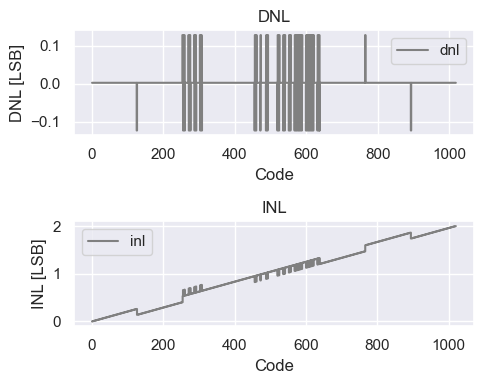

In [20]:
# observe the inl and dnl
fig, ax = plt.subplots(2,1,figsize=(5, 4))
ax[1].step(dout_dec_trans, inl, label='inl', color='gray')
ax[1].set_xlabel('Code')
ax[1].set_ylabel('INL [LSB]')
ax[1].set_title('INL')
ax[1].grid(True)
ax[1].legend()
ax[0].step(dout_dec_trans[:-1], dnl, label='dnl', color='gray')
ax[0].set_xlabel('Code')
ax[0].set_ylabel('DNL [LSB]')
ax[0].set_title('DNL')
ax[0].grid(True)
ax[0].legend()
fig.tight_layout()

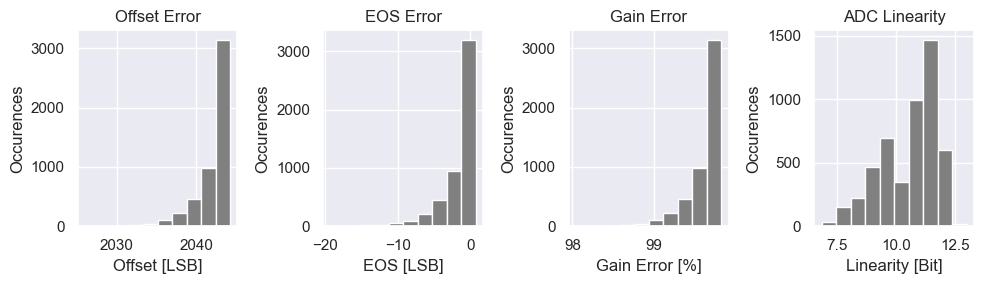

In [21]:
# observe the histogram of the linear errors of the ADC
fig, ax = plt.subplots(1,4,figsize=(10, 3))
ax[0].hist(adc_offsets.flatten(), bins=10, label='offset', color='gray')
ax[0].set_xlabel('Offset [LSB]')
ax[0].set_ylabel('Occurences')
ax[0].set_title('Offset Error')
ax[0].grid(True)
#ax[0].legend()
ax[1].hist(adc_eos.flatten(), bins=10, label='eos', color='gray')
ax[1].set_xlabel('EOS [LSB]')
ax[1].set_ylabel('Occurences')
ax[1].set_title('EOS Error')
ax[1].grid(True)
#ax[1].legend()
ax[2].hist(adc_gainerr.flatten(), bins=10, label='gain', color='gray')
ax[2].set_xlabel('Gain Error [%]')
ax[2].set_ylabel('Occurences')
ax[2].set_title('Gain Error')
ax[2].grid(True)

ax[3].hist(linearities.flatten(), bins=10, label='linearity', color='gray')
ax[3].set_xlabel('Linearity [Bit]')
ax[3].set_ylabel('Occurences')
ax[3].set_title('ADC Linearity')
ax[3].grid(True)
#ax[2].legend()
fig.tight_layout()

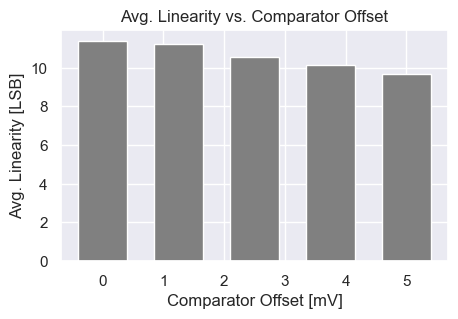

In [22]:
# observe the average linearity of the ADC against comparator offset
fig, ax = plt.subplots(1,1,figsize=(5, 3))
ax.bar(comp_offsets/mV, avg_linearity, label='avg linearity', color='gray')
ax.set_xlabel('Comparator Offset [mV]')
ax.set_ylabel('Avg. Linearity [LSB]')
ax.set_title('Avg. Linearity vs. Comparator Offset')
ax.grid(True)

<h2 align="left"> Successive Approximation Register (SAR) ADC - Top Plate Sampling & Monotonic SAR</h2>

<p align="justify">

</p>

INSERIR IMAGEM DE UM SAR ADC DIFEERENCIAL COM TOP PLATE SAMPLING E MONOTONICO

INSERIR IMAGEM DA OPERAÇÃO DE DIVISÃO DO DOMÍNIO DE BUSCA COM O ALGORITMO MONOTONICO

INSERIR IMAGEM DA CONFIGURAÇÃO DO ADC EM CADA PASSO DE CONVERSÃO

In [23]:
# setup the ADC parameters
vref      = vdd   # reference voltage of the whole 2-step adc

adc_gain  = 1
vref      = vref / adc_gain
vrefp     = vcm + vref/2
vrefn     = vcm - vref/2
Nbits     = 10
vlsb      = vref/(2**Nbits)

vin1    = np.linspace(-vref, vref, Np) # ramp input for an equal probability distribution of the input signal
vin1p   = vin1/2 + vcm
vin1n   = -vin1/2 + vcm

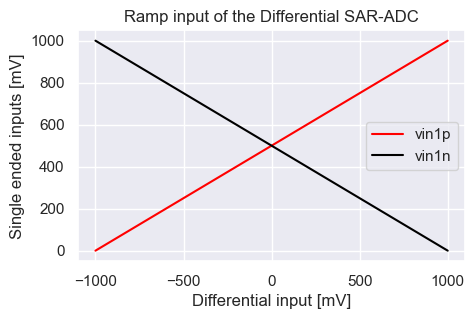

In [24]:
# observe the ramp inputs of the adc
fig, ax = plt.subplots(1,1,figsize=(5, 3))
ax.plot(vin1/mV, vin1p/mV, label='vin1p', color='red')
ax.plot(vin1/mV, vin1n/mV, label='vin1n', color='black')
ax.set_xlabel('Differential input [mV]')
ax.set_ylabel('Single ended inputs [mV]')
ax.set_title('Ramp input of the Differential SAR-ADC')
ax.grid(True)
ax.legend()

In [25]:
avg_linearity = np.zeros(NUM_COMP_OFSTS)
linearities = np.zeros((NUM_CIRCUITS, NUM_COMP_OFSTS))

adc_offsets = np.zeros((NUM_CIRCUITS, NUM_COMP_OFSTS))
adc_eos     = np.zeros((NUM_CIRCUITS, NUM_COMP_OFSTS))
adc_gainerr = np.zeros((NUM_CIRCUITS, NUM_COMP_OFSTS))

comp_offsets = np.linspace(0, MAX_COMP_OFST, NUM_COMP_OFSTS)

#vin1 = np.array([-vrefp, -vcm/2, vrefn, vcm, vrefp])
#vin1 = np.array([vcm,  vrefp])
vin1p   = vin1/2 + vcm
vin1n   = -vin1/2 + vcm

for i, comp_ofst in enumerate(comp_offsets):
    for j in range(NUM_CIRCUITS):
        
        # setup CDAC capacitor array
        
        # NOTE: In this architecture, the first sampling phase 
        # can be used to directly obtain the MSB of the ADC
        # and as such we don't need to use the CDAC array in the first phase
        # removing the necessity of the MSB capacitor in the CDAC array
        
        # positive comparator input rail
        num_caps_cdac   = Nbits-1 # number of capacitors in the CDAC array (N-1 binary weighted capacitors + 1 residue capacitor)
        unitary_caps    = np.ones(2**(num_caps_cdac))
        # setup random capacitor mismatch 
        cap_error       = normal(CAP_MISMATCH_MEAN, CAP_MISMATCH_STD, len(unitary_caps))
        caps            = unitary_caps*( 1 + cap_error)
        # setup residue capacitor
        pos_cres = caps[-1] # the last capacitor never gets accessed when aggregating the capacitors in the CDAC array
        # aggregate the capacitors in the CDAC array
        pos_cdac = np.array([
            np.sum(caps[2**k - 1:2**(k+1)-1])
            for k in range(num_caps_cdac)
        ])
        pos_cdac = pos_cdac[::-1] # reverse the array to match the binary weighted architecture
        pos_ctotal = np.sum(pos_cdac) + pos_cres
        
        # negative comparator input rail
        #num_caps_cdac   = Nbits # number of capacitors in the CDAC array (N binary weighted capacitors + 1 residue capacitor)
        unitary_caps    = np.ones(2**(num_caps_cdac))
        # setup random capacitor mismatch 
        cap_error       = normal(CAP_MISMATCH_MEAN, CAP_MISMATCH_STD, len(unitary_caps))
        caps            = unitary_caps*( 1 + cap_error)
        
        # setup residue capacitor
        neg_cres = caps[-1] # the last capacitor never gets accessed when aggregating the capacitors in the CDAC array
        # aggregate the capacitors in the CDAC array
        neg_cdac = np.array([
            np.sum(caps[2**k - 1:2**(k+1)-1])
            for k in range(num_caps_cdac)
        ])
        neg_cdac = neg_cdac[::-1] # reverse the array to match the binary weighted architecture
        neg_ctotal = np.sum(neg_cdac) + neg_cres
        
        # setup the comparator
        # the comparator is centered at vcm in this single ended architecture
        vcomp_offset = normal(0.0, comp_ofst, 1)[0] # comparator offset
        
        # setup the CDAC's top plate node voltage
        vp = np.zeros( (Nbits+1, len(vin1)) ) # an aditional phase is required when sampling vin to the bot plate 
        vn = np.zeros( (Nbits+1, len(vin1)) )
        
        # sampling phase : top plate sampling
        vp[0,:] = vin1p
        vn[0,:] = vin1n
        
        # setup the binary array that enables the control 
        # of the capacitors connected to Vrefp and Vrefn
        # in the CDAC array
        dout     = np.zeros( (Nbits, len(vin1)) ) # output of the control logic
        dout_neg = 1-dout
        
        # setup the charge array to register 
        # the amount of charge drawn from Vrefp
        charge_vrefp = np.zeros( (Nbits+1, len(vin1)) )
        
        # because we are using top plate sampling,
        
        
        # we can either:
        # raise the vn voltage when deciding a one
        # raise the vp voltage when deciding a zero
        # (independantly in each array)
        # but this means that both the voltages vn and vp 
        # will drift towards vrefp, and the differential pair
        # of the comparator must be implemented using a PMOS 
        # pair
        
        # or we can:
        # lower the vn voltage when deciding a zero
        # lower the vp voltage when deciding a one
        # (independantly in each array)
        # but this means that both the voltages vn and vp 
        # will drift towards vrefn, and the differential pair
        # of the comparator must be implemented using a NMOS
        # pair (which is has a faster settling than a PMOS pair)
        
        cpos_vrefp = (1-dout)[:-1,:].T @ pos_cdac.reshape(-1, 1) + pos_cres
        # compute the total capacitance connected to Vrefn
        # after connecting all the capacitors to Vrefn
        cpos_vrefn = dout[:-1,:].T @ pos_cdac.reshape(-1, 1) 
        
        # negative comparator input rail
        # compute the total capacitance connected to Vrefp
        cneg_vrefp = dout_neg[:-1,:].T @ neg_cdac.reshape(-1, 1) + neg_cres
        # compute the total capacitance connected to Vrefn
        # after connecting all the capacitors to Vrefn
        cneg_vrefn = (1-dout_neg)[:-1,:].T @ neg_cdac.reshape(-1, 1) 
        
        cpos_vrefp_old = cpos_vrefp.T # generic way! (its actually a null vector)
        cpos_vrefn_old = cpos_vrefn.T
        
        cneg_vrefp_old = cneg_vrefp.T
        cneg_vrefn_old = cneg_vrefn.T
        
        charge_vrefp[0,:] = (vp[0,:]-vrefp)*cpos_vrefp_old \
                            +  (vn[0,:]-vrefp)*cneg_vrefp_old
        
        # compare assuming vp higher than vn, once we are using 
        # top plate sampling and the signal at the top plate is not inverted
        dout[0, :] = ( vp[0,:] - vn[0,:] > vcomp_offset ).astype(int)
        # let us use the dout_neg variable as a 
        # control binary word for the negative array
        # and not the negated dout variable simply.
        dout_neg[0, :] = dout[0, :]
        
        # this way we can effectively change
        # only the positive or the negative array
        # independantly in each turn
        # if vip>vin , change only the negative array, switching the corresponding binary cap from vren to vrefp
        # if vip<vin , change only the positive array, switching the corresponding binary cap from vren to vrefp
        # thus achieving a monotonic approach
        
        
        
        # perform each conversion step
        for k in range(1, Nbits):
            # setup the control logic to use the DAC array to check 
            # if the input signal is greater than the top plate voltage
            # (NON-MONOTONIC APPROACH)
            
            cpos_vrefp = (1-dout)[:-1,:].T @ pos_cdac.reshape(-1, 1) + pos_cres
            # compute the total capacitance connected to Vrefn
            # after connecting all the capacitors to Vrefn
            cpos_vrefn = dout[:-1,:].T @ pos_cdac.reshape(-1, 1) 
            
            # negative comparator input rail
            # compute the total capacitance connected to Vrefp
            cneg_vrefp = dout_neg[:-1,:].T @ neg_cdac.reshape(-1, 1) + neg_cres
            # compute the total capacitance connected to Vrefn
            # after connecting all the capacitors to Vrefn
            cneg_vrefn = (1-dout_neg)[:-1,:].T @ neg_cdac.reshape(-1, 1) 
            
            cpos_vrefp = cpos_vrefp.T # generic way! (its actually a null vector)
            cpos_vrefn = cpos_vrefn.T
            
            cneg_vrefp = cneg_vrefp.T
            cneg_vrefn = cneg_vrefn.T
            
            # compute the top plate voltage using charge conservation principle
            # between successive phases
            vp[k,:] = vp[k-1,:] + ( vrefn*(cpos_vrefn - cpos_vrefn_old) + vrefp*(cpos_vrefp - cpos_vrefp_old) ) / pos_ctotal
            vn[k,:] = vn[k-1,:] + ( vrefn*(cneg_vrefn - cneg_vrefn_old) + vrefp*(cneg_vrefp - cneg_vrefp_old) ) / neg_ctotal
            
            # compute the amount of charge drawn from Vrefp
            charge_vrefp[k,:] = (vp[k,:]-vrefp)*cpos_vrefp + \
                        (vn[k,:]-vrefp)*cneg_vrefp
            # compute the amount of charge drawn from Vrefp
            
            dout[k,:] = ( vp[k,:] - vn[k,:] > vcomp_offset ).astype(int)
            dout_neg[k,:] = dout[k,:]
            
            # update the old capacitance values
            cpos_vrefp_old = cpos_vrefp
            cpos_vrefn_old = cpos_vrefn
            
            cneg_vrefp_old = cneg_vrefp
            cneg_vrefn_old = cneg_vrefn
        
        k += 1
        
        # program the residue capacitor using the last bit of the ADC
        cpos_vrefp = (1-dout)[:-1,:].T @ pos_cdac.reshape(-1, 1) + ((1-dout)[-1,:]*pos_cres).reshape(-1,1)
        # compute the total capacitance connected to Vrefn
        # after connecting all the capacitors to Vrefn
        cpos_vrefn = dout[:-1,:].T @ pos_cdac.reshape(-1, 1) + (dout[-1,:]*pos_cres).reshape(-1,1)
        
        # negative comparator input rail
        # compute the total capacitance connected to Vrefp
        cneg_vrefp = dout_neg[:-1,:].T @ neg_cdac.reshape(-1, 1) + (dout_neg[-1,:]*neg_cres).reshape(-1,1)
        # compute the total capacitance connected to Vrefn
        # after connecting all the capacitors to Vrefn
        cneg_vrefn = (1-dout_neg)[:-1,:].T @ neg_cdac.reshape(-1, 1) + ((1-dout_neg)[-1,:]*neg_cres).reshape(-1,1)
            
        cpos_vrefp = cpos_vrefp.T
        cpos_vrefn = cpos_vrefn.T
        
        cneg_vrefp = cneg_vrefp.T
        cneg_vrefn = cneg_vrefn.T
        
        vp[k,:] = vp[k-1,:] + ( vrefn*(cpos_vrefn - cpos_vrefn_old) + vrefp*(cpos_vrefp - cpos_vrefp_old) ) / pos_ctotal
        vn[k,:] = vn[k-1,:] + ( vrefn*(cneg_vrefn - cneg_vrefn_old) + vrefp*(cneg_vrefp - cneg_vrefp_old) ) / neg_ctotal
            
        # compute the amount of charge drawn from Vrefp
        charge_vrefp[k,:] = (vp[k,:]-vrefp)*cpos_vrefp + \
            (vn[k,:]-vrefp)*cneg_vrefp
        # compute the amount of charge drawn from Vrefp
        
        # obtain the residue voltage
        vres = vp[-1,:] - vn[-1,:]
        
        # obtain the amount of energy drawn from Vrefp
        energy_vrefp = np.sum(charge_vrefp, axis=0) * vrefp
        
        # comput the non linear errors of the adc
        # compute the transition voltages of the ADC and its inl / dnl
        dout_dec        = bin2dec(dout, width=Nbits, reverse=False)
        dout_dec_trans  = dout_dec[ np.where(np.diff(dout_dec) > 0 ) ]
        vtrans          = vin1[ np.where(np.diff(dout_dec) > 0 ) ]
        
        vlsb_measured = (vtrans[-1] - vtrans[0])/(2**Nbits - 2)
        dnl = np.diff(vtrans)/vlsb_measured - 1
        inl = np.array([0] + np.cumsum(dnl).tolist())
        adc_linearity = Nbits - np.log2(np.max(inl) - np.min(inl))
        linearities[j, i] = adc_linearity
        
        # compute the linear errors of the adc
        # offset error
        offset              = (vtrans[-1] - vtrans[0])/vlsb
        adc_offsets[j, i]   = offset
        # end of scale error
        eos_error       = (vtrans[-1] - (2**Nbits - 1)*vlsb)/vlsb
        adc_eos[j, i]   = eos_error
        # gain error
        gain_error          = 100*( (vtrans[-1] - vtrans[0])/((2**Nbits - 1)*vlsb_measured - 0) - 1 )
        adc_gainerr[j, i]   = gain_error
        

    avg_linearity[i] = np.mean(linearities[:, i])
    
print("CDAC Capacitance     : ", pos_cdac, " (F/F)")
print("Residue Capacitance  : ", pos_cres, " (F/F)")
print("Total Capacitance    : ", pos_ctotal, " (F/F)")
print("Comparator Threshold : ", vcomp_offset/mV, " (mV)")

CDAC Capacitance     :  [255.71856151 127.95535285  64.03114349  32.0135469   16.00576182
   8.00093946   4.01764946   2.01040822   0.99361285]  (F/F)
Residue Capacitance  :  0.9946941318159787  (F/F)
Total Capacitance    :  511.74167069490625  (F/F)
Comparator Threshold :  2.6415428440670605  (mV)


/var/folders/vv/xctyh4bd2td6k2w_gvh_t2vr0000gn/T/ipykernel_15341/1497454566.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


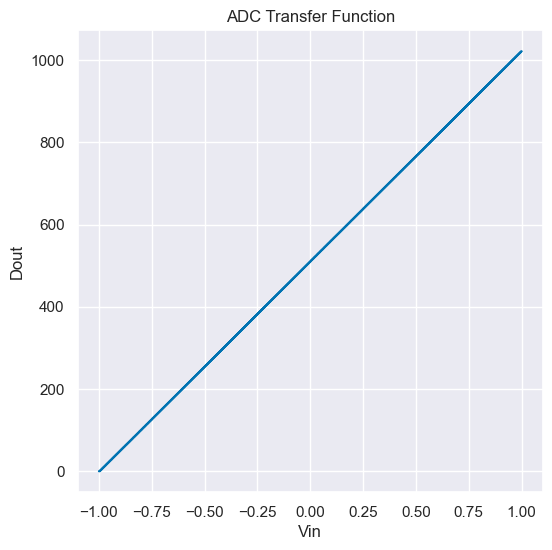

In [26]:
# observe dout against vin
fig, ax = plt.subplots(figsize=(6, 6))
ax.step(vin1, dout_dec)
ax.set_xlabel('Vin')
ax.set_ylabel('Dout')
ax.grid(True)
ax.set_title('ADC Transfer Function')
fig.show()

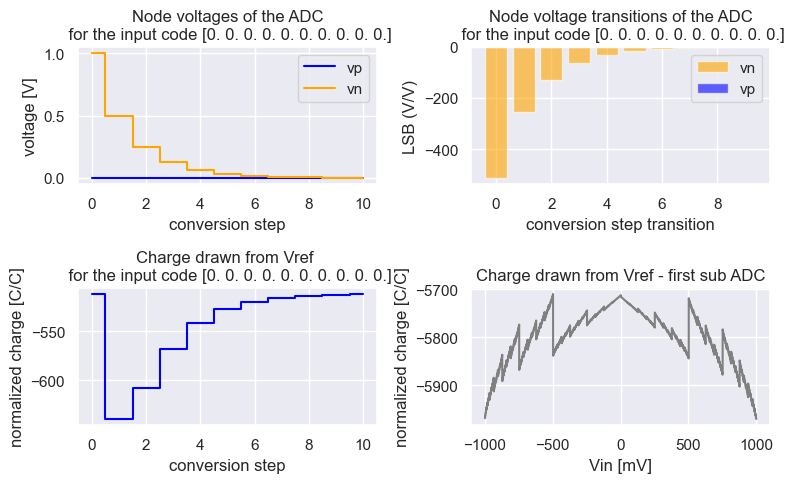

In [27]:
# observe the voltages at the vp and vn nodes of the first sub ADC in each conversion step
fig, ax = plt.subplots(2,2,figsize=(8,5))
#vin = vtrans_first[len(vtrans_first)//2]
#idx = len(vp_first[0, :])//2 + 1
idx = 1

ax[0,0].step(list(range(len(vp[:, idx][0:]))),vp[:, idx][0:], label='vp', color='blue', where="mid")
ax[0,0].step(list(range(len(vn[:, idx][0:]))),vn[:, idx][0:], label='vn', color='orange', where="mid")
ax[0,0].set_xlabel('conversion step')
ax[0,0].set_ylabel('voltage [V]')
ax[0,0].set_title(f'Node voltages of the ADC\n for the input code {dout[:,idx]}')
ax[0,0].grid(True)
ax[0,0].legend()

# plot the difference between each vn and vp node voltages in relation to the true measured vlsb
vn_trans = np.diff(vn[:, idx][0:])/vlsb
vp_trans = np.diff(vp[:, idx][0:])/vlsb
ax[0,1].bar(list(range(len(vn_trans))), vn_trans, label="vn", color="orange", alpha=0.6)
ax[0,1].bar(list(range(len(vp_trans))), vp_trans, label="vp", color="blue", alpha=0.6)
ax[0,1].set_xlabel('conversion step transition')
ax[0,1].set_ylabel('LSB (V/V)')
ax[0,1].set_title(f'Node voltage transitions of the ADC\n for the input code {dout[:,idx]}')
ax[0,1].grid(True)
ax[0,1].legend()


# observe the charge at the end of each conversion step
ax[1,0].step(list(range(len(charge_vrefp))), charge_vrefp[:, idx], label='charge drawn from vref', color='blue', where="mid")
ax[1,0].set_xlabel('conversion step')
ax[1,0].set_ylabel('normalized charge [C/C]')
ax[1,0].set_title(f'Charge drawn from Vref \n for the input code {dout[:,idx]}')
ax[1,0].grid(True)

# observe the energy drawn from vrefp
ax[1,1].step(vin1/mV, energy_vrefp, label='energy drawn from vref', color='gray', where="mid")
ax[1,1].set_xlabel('Vin [mV]')
ax[1,1].set_ylabel('normalized charge [C/C]')
ax[1,1].set_title('Charge drawn from Vref - first sub ADC')
ax[1,1].grid(True)

fig.tight_layout()

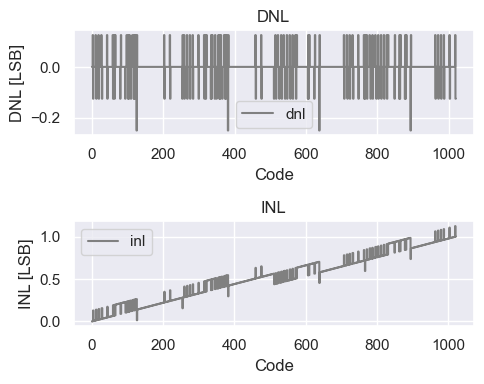

In [28]:
# observe the inl and dnl
fig, ax = plt.subplots(2,1,figsize=(5, 4))
ax[1].step(dout_dec_trans, inl, label='inl', color='gray')
ax[1].set_xlabel('Code')
ax[1].set_ylabel('INL [LSB]')
ax[1].set_title('INL')
ax[1].grid(True)
ax[1].legend()
ax[0].step(dout_dec_trans[:-1], dnl, label='dnl', color='gray')
ax[0].set_xlabel('Code')
ax[0].set_ylabel('DNL [LSB]')
ax[0].set_title('DNL')
ax[0].grid(True)
ax[0].legend()
fig.tight_layout()

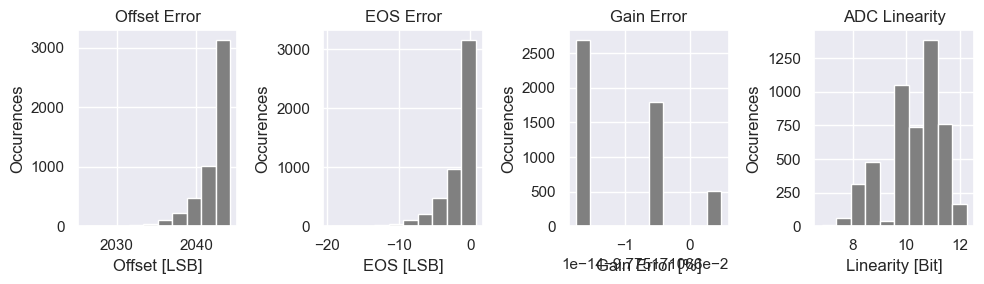

In [29]:
# observe the histogram of the linear errors of the ADC
fig, ax = plt.subplots(1,4,figsize=(10, 3))
ax[0].hist(adc_offsets.flatten(), bins=10, label='offset', color='gray')
ax[0].set_xlabel('Offset [LSB]')
ax[0].set_ylabel('Occurences')
ax[0].set_title('Offset Error')
ax[0].grid(True)
#ax[0].legend()
ax[1].hist(adc_eos.flatten(), bins=10, label='eos', color='gray')
ax[1].set_xlabel('EOS [LSB]')
ax[1].set_ylabel('Occurences')
ax[1].set_title('EOS Error')
ax[1].grid(True)
#ax[1].legend()
ax[2].hist(adc_gainerr.flatten(), bins=10, label='gain', color='gray')
ax[2].set_xlabel('Gain Error [%]')
ax[2].set_ylabel('Occurences')
ax[2].set_title('Gain Error')
ax[2].grid(True)

ax[3].hist(linearities.flatten(), bins=10, label='linearity', color='gray')
ax[3].set_xlabel('Linearity [Bit]')
ax[3].set_ylabel('Occurences')
ax[3].set_title('ADC Linearity')
ax[3].grid(True)
#ax[2].legend()
fig.tight_layout()

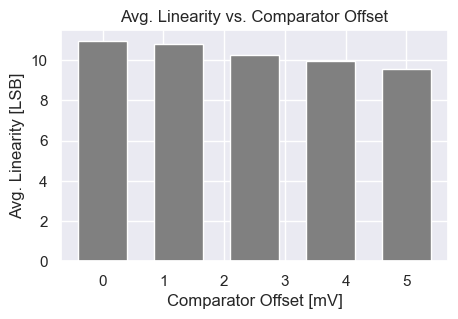

In [30]:
# observe the average linearity of the ADC against comparator offset
fig, ax = plt.subplots(1,1,figsize=(5, 3))
ax.bar(comp_offsets/mV, avg_linearity, label='avg linearity', color='gray')
ax.set_xlabel('Comparator Offset [mV]')
ax.set_ylabel('Avg. Linearity [LSB]')
ax.set_title('Avg. Linearity vs. Comparator Offset')
ax.grid(True)

<h2 align="left"> Successive Approximation Register (SAR) ADC - V<sub>CM</sub>-Based with Bottom Plate Sampling and a Split Capacitor Array Divided by a Capacitive Voltage Divider</h2>

<p align="justify">
    
</p>


In [31]:
# setup the ADC parameters
vref      = vdd   # reference voltage of the whole 2-step adc

adc_gain  = 1
vref      = vref / adc_gain
vrefp     = vcm + vref/2
vrefn     = vcm - vref/2
Nbits_dac1     = 2  # the number of bits of the first DAC in the splitted architecture
Nbits_dac2     = 3  # the number of bits of the second DAC in the splitted architecture
vlsb      = vref/(2**Nbits)

vin1    = np.linspace(-vref, vref, Np) # ramp input for an equal probability distribution of the input signal
vin1p   = vin1/2 + vcm
vin1n   = -vin1/2 + vcm

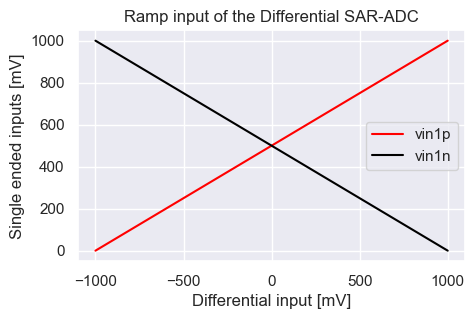

In [32]:
# observe the ramp inputs of the adc
fig, ax = plt.subplots(1,1,figsize=(5, 3))
ax.plot(vin1/mV, vin1p/mV, label='vin1p', color='red')
ax.plot(vin1/mV, vin1n/mV, label='vin1n', color='black')
ax.set_xlabel('Differential input [mV]')
ax.set_ylabel('Single ended inputs [mV]')
ax.set_title('Ramp input of the Differential SAR-ADC')
ax.grid(True)
ax.legend()

In [37]:
avg_linearity = np.zeros(NUM_COMP_OFSTS)
linearities = np.zeros((NUM_CIRCUITS, NUM_COMP_OFSTS))

adc_offsets = np.zeros((NUM_CIRCUITS, NUM_COMP_OFSTS))
adc_eos     = np.zeros((NUM_CIRCUITS, NUM_COMP_OFSTS))
adc_gainerr = np.zeros((NUM_CIRCUITS, NUM_COMP_OFSTS))


comp_offsets = np.linspace(0, MAX_COMP_OFST, NUM_COMP_OFSTS)

#vin1 = np.array([-vrefp, -vcm/2, vrefn, vcm, vrefp])
#vin1 = np.array([vcm,  vrefp])
vin1p   = vin1/2 + vcm
vin1n   = -vin1/2 + vcm

VERBOSE = True

for i, comp_ofst in enumerate(comp_offsets):
    for j in range(NUM_CIRCUITS):
        
        # setup CDAC capacitor array
        
        # NOTE: In this architecture, the first sampling phase 
        # can be used to directly obtain the MSB of the ADC
        # and as such we don't need to use the CDAC array in the first phase
        # removing the necessity of the MSB capacitor in the CDAC array
        
        # positive comparator input rail
        num_caps_cdac1  = Nbits_dac1 - 1 # number of capacitors in the CDAC array (N-1 binary weighted capacitors)
        num_caps_cdac2  = Nbits_dac2 # number of capacitor in the second CDAC array (N binary weighted capacitors + 1 residue capacitor)
        unitary_caps    = np.ones(2**(num_caps_cdac1)-1)
        
        # setup the first cdac array
        # setup random capacitor mismatch 
        cap_error       = normal(CAP_MISMATCH_MEAN, CAP_MISMATCH_STD, len(unitary_caps))
        caps            = unitary_caps*( 1 + cap_error)
        # aggregate the capacitors in the CDAC array
        pos_cdac1 = np.array([
            np.sum(caps[2**k - 1:2**(k+1)-1])
            for k in range(num_caps_cdac1)
        ])
        pos_cdac1 = pos_cdac1[::-1] # reverse the array to match the binary weighted architecture
        pos_ctotal1 = np.sum(pos_cdac1)
        
        # setup the second positive rail cdac array
        unitary_caps    = np.ones(2**(num_caps_cdac2))
        # setup random capacitor mismatch 
        cap_error       = normal(CAP_MISMATCH_MEAN, CAP_MISMATCH_STD, len(unitary_caps))
        caps            = unitary_caps*( 1 + cap_error)
        # aggregate the capacitors in the CDAC array
        pos_cres = caps[-1] # we can aggregate the last capacitor in the second cdac array as the residue capacitor
        pos_cdac2 = np.array([
            np.sum(caps[2**k - 1:2**(k+1)-1])
            for k in range(num_caps_cdac2)
        ])
        pos_cdac2 = np.array(pos_cdac2[::-1].tolist() + [pos_cres]) # reverse the array to match the binary weighted architecture
        pos_ctotal2 = np.sum(pos_cdac2)
        
        # setup the voltage dividing capacitor 
        # enabling the splitted architecture
        unitary_caps    = np.ones(2**(num_caps_cdac1))
        cap_error       = normal(CAP_MISMATCH_MEAN, CAP_MISMATCH_STD,len(unitary_caps))
        unitary_caps    = unitary_caps * (1 + cap_error)
        pos_cdiv        = np.sum(unitary_caps)
        
        pos_ctotal      = pos_ctotal1 + pos_cdiv/(pos_cdiv + pos_ctotal2)
        
        if VERBOSE:
            print("Positive Cdac 1      : ", pos_cdac1, " (F/F)")
            print("Positive Cdac 2      : ", pos_cdac2, " (F/F)")
            print("Positive Cdac Div Cap: ", pos_cdiv, " (F/F)")
        
        # negative comparator input rail
        #num_caps_cdac   = Nbits # number of capacitors in the CDAC array (N binary weighted capacitors + 1 residue capacitor)
        unitary_caps    = np.ones(2**(num_caps_cdac1)-1)
        # setup random capacitor mismatch 
        cap_error       = normal(CAP_MISMATCH_MEAN, CAP_MISMATCH_STD, len(unitary_caps))
        caps            = unitary_caps*( 1 + cap_error)
        
        # setup residue capacitor
        # aggregate the capacitors in the CDAC array
        neg_cdac1 = np.array([
            np.sum(caps[2**k - 1:2**(k+1)-1])
            for k in range(num_caps_cdac1)
        ])
        neg_cdac1 = neg_cdac1[::-1] # reverse the array to match the binary weighted architecture
        neg_ctotal1 = np.sum(neg_cdac1)
        
        # setup the second positive rail cdac array
        unitary_caps    = np.ones(2**(num_caps_cdac2))
        # setup random capacitor mismatch 
        cap_error       = normal(CAP_MISMATCH_MEAN, CAP_MISMATCH_STD, len(unitary_caps))
        caps            = unitary_caps*( 1 + cap_error)
        # aggregate the capacitors in the CDAC array
        neg_cres = caps[-1]
        neg_cdac2 = np.array([
            np.sum(caps[2**k - 1:2**(k+1)-1])
            for k in range(num_caps_cdac2)
        ])
        neg_cdac2 = np.array(neg_cdac2[::-1].tolist() + [neg_cres]) # reverse the array to match the binary weighted architecture
        neg_ctotal2 = np.sum(neg_cdac2)
        
        # setup the voltage dividing capacitor 
        # enabling the splitted architecture
        unitary_caps    = np.ones(2**(num_caps_cdac1))
        cap_error       = normal(CAP_MISMATCH_MEAN, CAP_MISMATCH_STD, len(unitary_caps))
        unitary_caps    = unitary_caps * (1 + cap_error)
        neg_cdiv        = np.sum(unitary_caps)
        
        neg_ctotal      = neg_ctotal1 + neg_cdiv/(neg_cdiv + neg_ctotal2)
        
        if VERBOSE:
            print("Negative Cdac 1      : ", neg_cdac1, " (F/F)")
            print("Negative Cdac 2      : ", neg_cdac2, " (F/F)")
            print("Negative Cdac Div Cap: ", neg_cdiv, " (F/F)")
        
        # setup the comparator
        # the comparator is centered at vcm in this single ended architecture
        vcomp_offset = normal(0.0, comp_ofst, 1)[0] # comparator offset
        
        # setup the CDAC's top plate node voltage
        vp = np.zeros( (Nbits_dac1 + Nbits_dac1 + 2, len(vin1)) ) # an aditional phase is required when sampling vin to the bot plate 
        vn = np.zeros( (Nbits_dac1 + Nbits_dac1 + 2, len(vin1)) )
        
        # setup the binary array that enables the control 
        # of the capacitors connected to Vrefp and Vrefn
        # in the CDAC array
        dout     = np.zeros( (Nbits_dac1 + Nbits_dac2, len(vin1)) ) # output of the control logic
        dout_neg = np.zeros( (Nbits_dac1 + Nbits_dac2, len(vin1)) )
        
        # sampling phase : bottom plate sampling
        vp[0,:] = vcm
        vn[0,:] = vcm
        
        
        # positive comparator input rail
        # compute the total capacitance connected to Vrefp
        cpos1_vrefp = dout_neg[:Nbits_dac1-1,:].T @ pos_cdac1.reshape(-1, 1)
        cpos2_vrefp = dout_neg[Nbits_dac1-1:,:].T @ pos_cdac2.reshape(-1, 1)
        cpos2_vrefp = pos_cdiv / (pos_cdiv + cpos2_vrefp)
        
        cpos1_vrefp_old = cpos1_vrefp.T
        cpos2_vrefp_old = cpos2_vrefp.T
        
        # compute the total capacitance connected to Vrefn
        cpos1_vrefn = dout[:Nbits_dac1-1,:].T @ pos_cdac1.reshape(-1, 1)
        cpos2_vrefn = dout[Nbits_dac1-1:,:].T @ pos_cdac2.reshape(-1, 1)
        cpos2_vrefn = pos_cdiv / (pos_cdiv + cpos2_vrefn)
        
        cpos1_vrefn_old = cpos1_vrefn.T
        cpos2_vrefn_old = cpos2_vrefn.T
        
        # compute the total capacitance connected to Vcm
        cpos1_vcm_old   = pos_ctotal1 - cpos1_vrefp_old - cpos1_vrefn_old
        cpos2_vcm_old   = pos_ctotal2 - cpos2_vrefp_old - cpos2_vrefn_old
        
        
        # negative comparator input rail
        # compute the total capacitance connected to Vrefp
        cneg1_vrefp = dout[:Nbits_dac1-1,:].T @ neg_cdac1.reshape(-1, 1)
        cneg2_vrefp = dout[Nbits_dac1-1:,:].T @ neg_cdac2.reshape(-1, 1)
        cneg2_vrefp = neg_cdiv / (neg_cdiv + cneg2_vrefp)
        
        cneg1_vrefp_old = cneg1_vrefp.T
        cneg2_vrefp_old = cneg2_vrefp.T
        
        # compute the total capacitance connected to Vrefn
        cneg1_vrefn = dout_neg[:Nbits_dac1-1,:].T @ neg_cdac1.reshape(-1, 1)
        cneg2_vrefn = dout_neg[Nbits_dac1-1:,:].T @ neg_cdac2.reshape(-1, 1)
        cneg2_vrefn = neg_cdiv / (neg_cdiv + cneg2_vrefn)
        
        cneg1_vrefn_old = cneg1_vrefn.T
        cneg2_vrefn_old = cneg2_vrefn.T
        
        # compute the total capacitance connected to Vcm
        cneg1_vcm_old   = neg_ctotal - cneg1_vrefp_old - cneg1_vrefn_old
        cneg2_vcm_old   = neg_ctotal2 - cneg2_vrefp_old - cneg2_vrefn_old
        
        
        # charge redistribution phase : pass the charge from the bottom plate to the top plate
        vp[1,:] = vcm - vin1p + vcm
        vn[1,:] = vcm - vin1n + vcm
        
        # decide the first bit of the ADC for free, without using the CDAC array
        dout[0, :] = ( vp[1,:] - vn[1,:] < vcomp_offset ).astype(int)
        dout_neg[0, :] = 1 - dout[0, :]
        
        # setup the charge array to register 
        # the amount of charge drawn from Vrefp
        charge_vrefp = np.zeros( (Nbits_dac1 + Nbits_dac1+2, len(vin1)) )
        
        #charge_vrefp[0,:] = vrefp*(cpos_vrefp_old + cneg_vrefp_old)
        
        
        # perform each conversion step
        for k in range(2, Nbits_dac1+Nbits_dac2+1):
            
            # positive comparator input rail
            # compute the total capacitance connected to Vrefp
            cpos1_vrefp = dout_neg[:Nbits_dac1-1,:].T @ pos_cdac1.reshape(-1, 1)
            cpos2_vrefp = dout_neg[Nbits_dac1-1:,:].T @ pos_cdac2.reshape(-1, 1)
            cpos2_vrefp = pos_cdiv / (pos_cdiv + cpos2_vrefp)
            
            cpos1_vrefp = cpos1_vrefp.T
            cpos2_vrefp = cpos2_vrefp.T
            
            # compute the total capacitance connected to Vrefn
            cpos1_vrefn = dout[:Nbits_dac1-1,:].T @ pos_cdac1.reshape(-1, 1)
            cpos2_vrefn = dout[Nbits_dac1-1:,:].T @ pos_cdac2.reshape(-1, 1)
            cpos2_vrefn = pos_cdiv / (pos_cdiv + cpos2_vrefn)
            
            cpos1_vrefn = cpos1_vrefn.T
            cpos2_vrefn = cpos2_vrefn.T
            
            # compute the total capacitance connected to Vcm
            cpos1_vcm   = pos_ctotal1 - cpos1_vrefp - cpos1_vrefn
            cpos2_vcm   = pos_ctotal2 - cpos2_vrefp - cpos2_vrefn
            
            
            # negative comparator input rail
            # compute the total capacitance connected to Vrefp
            cneg1_vrefp = dout[:Nbits_dac1-1,:].T @ neg_cdac1.reshape(-1, 1)
            cneg2_vrefp = dout[Nbits_dac1-1:,:].T @ neg_cdac2.reshape(-1, 1)
            cneg2_vrefp = neg_cdiv / (neg_cdiv + cneg2_vrefp)
            
            cneg1_vrefp = cneg1_vrefp.T
            cneg2_vrefp = cneg2_vrefp.T
            
            # compute the total capacitance connected to Vrefn
            cneg1_vrefn = dout_neg[:Nbits_dac1-1,:].T @ neg_cdac1.reshape(-1, 1)
            cneg2_vrefn = dout_neg[Nbits_dac1-1:,:].T @ neg_cdac2.reshape(-1, 1)
            cneg2_vrefn = neg_cdiv / (neg_cdiv + cneg2_vrefn)
            
            cneg1_vrefn = cneg1_vrefn.T
            cneg2_vrefn = cneg2_vrefn.T
            
            # compute the total capacitance connected to Vcm
            cneg1_vcm   = neg_ctotal - cneg1_vrefp - cneg1_vrefn
            cneg2_vcm   = neg_ctotal2 - cneg2_vrefp - cneg2_vrefn
            
            # compute the top plate voltage using charge conservation principle
            # between successive phases
            vp[k,:] = vp[k-1,:] + ( vrefn*(cpos1_vrefn + cpos2_vrefn - cpos1_vrefn_old - cpos2_vrefn_old) + \
                vrefp*(cpos1_vrefp + cpos2_vrefp - cpos1_vrefp_old - cpos2_vrefp_old) + \
                    vcm*(cpos1_vcm + cpos2_vcm - cpos1_vcm_old - cpos2_vcm_old)  ) / pos_ctotal
            
            vn[k,:] = vn[k-1,:] + ( vrefn*(cneg1_vrefn + cneg2_vrefn - cneg1_vrefn_old - cneg2_vrefn_old) + \
                vrefp*(cneg1_vrefp + cneg2_vrefp - cneg1_vrefp_old - cneg2_vrefp_old) + \
                    vcm*(cneg1_vcm + cneg2_vcm - cneg1_vcm_old - cneg2_vcm_old)  ) / neg_ctotal
            
            
            # compute the amount of charge drawn from Vrefp
            #charge_vrefp[k-1,:] = vrefp*(cpos_vrefp + cneg_vrefp)
            # compute the amount of charge drawn from Vrefp
            
            # decide upon the next bit of the ADC
            dout[k-1,:] = ( vp[k,:] - vn[k,:] < vcomp_offset ).astype(int)
            dout_neg[k-1,:] = 1 - dout[k-1,:]
            
            # update the old capacitance values
            cpos1_vcm_old = cpos1_vcm.T
            cpos2_vcm_old = cpos2_vcm.T
            
            cpos1_vrefp_old = cpos1_vrefp.T
            cpos2_vrefp_old = cpos2_vrefp.T
            
            cpos1_vrefn_old = cpos1_vrefn.T
            cpos2_vrefn_old = cpos2_vrefn.T
            
            cneg1_vcm_old = cneg1_vcm.T
            cneg2_vcm_old = cneg2_vcm.T
            
            cneg1_vrefp_old = cneg1_vrefp.T
            cneg2_vrefp_old = cneg2_vrefp.T
            
            cneg1_vrefn_old = cneg1_vrefn.T
            cneg2_vrefn_old = cneg2_vrefn.T
        
        # obtain the residue voltage
        vres = vp[-1,:] - vn[-1,:]
        
        # obtain the amount of energy drawn from Vrefp
        energy_vrefp = np.sum(charge_vrefp, axis=0) * vrefp
        
        # comput the non linear errors of the adc
        # compute the transition voltages of the ADC and its inl / dnl
        dout_dec        = bin2dec(dout, width=Nbits, reverse=False)
        dout_dec_trans  = dout_dec[ np.where(np.diff(dout_dec) > 0 ) ]
        vtrans          = vin1[ np.where(np.diff(dout_dec) > 0 ) ]
        
        vlsb_measured = (vtrans[-1] - vtrans[0])/(2**Nbits - 2)
        dnl = np.diff(vtrans)/vlsb_measured - 1
        inl = np.array([0] + np.cumsum(dnl).tolist())
        adc_linearity = Nbits - np.log2(np.max(inl) - np.min(inl))
        linearities[j, i] = adc_linearity
        
        # compute the linear errors of the adc
        # offset error
        offset              = (vtrans[-1] - vtrans[0])/vlsb
        adc_offsets[j, i]   = offset
        # end of scale error
        eos_error       = (vtrans[-1] - (2**Nbits - 1)*vlsb)/vlsb
        adc_eos[j, i]   = eos_error
        # gain error
        gain_error          = 100*( (vtrans[-1] - vtrans[0])/((2**Nbits - 1)*vlsb - 0) - 1 )
        adc_gainerr[j, i]   = gain_error
        

    avg_linearity[i] = np.mean(linearities[:, i])
    
print("CDAC Capacitance     : ", pos_cdac, " (F/F)")
print("Residue Capacitance  : ", pos_cres, " (F/F)")
print("Total Capacitance    : ", pos_ctotal, " (F/F)")
print("Comparator Threshold : ", vcomp_offset/mV, " (mV)")

Positive Cdac 1      :  [0.98818653]  (F/F)
Positive Cdac 2      :  [3.99699434 1.99260334 0.99497405 1.00387191]  (F/F)
Positive Cdac Div Cap:  1.9881618761018705  (F/F)
Negative Cdac 1      :  [0.99197219]  (F/F)
Negative Cdac 2      :  [3.98814708 2.00748998 1.01945944 1.00145547]  (F/F)
Negative Cdac Div Cap:  2.0224959720343074  (F/F)


ValueError: could not broadcast input array from shape (8192,8192) into shape (8192,)

In [ ]:
# observe dout against vin
fig, ax = plt.subplots(figsize=(6, 6))
ax.step(vin1, dout_dec)
ax.set_xlabel('Vin')
ax.set_ylabel('Dout')
ax.grid(True)
ax.set_title('ADC Transfer Function')
fig.show()

In [ ]:
# observe the voltages at the vp and vn nodes of the first sub ADC in each conversion step
fig, ax = plt.subplots(2,2,figsize=(8,5))
#vin = vtrans_first[len(vtrans_first)//2]
#idx = len(vp_first[0, :])//2 + 1
idx = 0

ax[0,0].step(list(range(len(vp[:, idx][0:]))),vp[:, idx][0:], label='vp', color='blue', where="mid")
ax[0,0].step(list(range(len(vn[:, idx][0:]))),vn[:, idx][0:], label='vn', color='orange', where="mid")
ax[0,0].set_xlabel('conversion step')
ax[0,0].set_ylabel('voltage [V]')
ax[0,0].set_title(f'Node voltages of the ADC\n for the input code {dout[:,idx]}')
ax[0,0].grid(True)
ax[0,0].legend()

# plot the difference between each vn and vp node voltages in relation to the true measured vlsb
vn_trans = np.diff(vn[:, idx][0:])/vlsb
vp_trans = np.diff(vp[:, idx][0:])/vlsb
ax[0,1].bar(list(range(len(vn_trans))), vn_trans, label="vn", color="orange", alpha=0.6)
ax[0,1].bar(list(range(len(vp_trans))), vp_trans, label="vp", color="blue", alpha=0.6)
ax[0,1].set_xlabel('conversion step transition')
ax[0,1].set_ylabel('LSB (V/V)')
ax[0,1].set_title(f'Node voltage transitions of the ADC\n for the input code {dout[:,idx]}')
ax[0,1].grid(True)
ax[0,1].legend()


# observe the charge at the end of each conversion step
ax[1,0].step(list(range(len(charge_vrefp))), charge_vrefp[:, idx], label='charge drawn from vref', color='blue', where="mid")
ax[1,0].set_xlabel('conversion step')
ax[1,0].set_ylabel('normalized charge [C/C]')
ax[1,0].set_title(f'Charge drawn from Vref \n for the input code {dout[:,idx]}')
ax[1,0].grid(True)

# observe the energy drawn from vrefp
ax[1,1].step(vin1/mV, energy_vrefp, label='energy drawn from vref', color='gray', where="mid")
ax[1,1].set_xlabel('Vin [mV]')
ax[1,1].set_ylabel('normalized charge [C/C]')
ax[1,1].set_title('Charge drawn from Vref - first sub ADC')
ax[1,1].grid(True)

fig.tight_layout()